In [17]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from sympy import false
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import Adam, SGD, RMSprop

In [18]:
def make_model():
    model = nn.Sequential(
        # Block 1
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        #Block 2
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Block 3
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Flatten(),
        nn.Linear(128 * 4 * 4, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 100)
    )
    return model

In [19]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [20]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])

train_set = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR100(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

classes = train_set.classes

Files already downloaded and verified


In [21]:
def evaluate(model, loader, criterion, device):
    model.eval()
    correct, total = 0, 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)

            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted==labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss/len(loader)
    val_acc = 100 * correct / total
    return val_loss, val_acc

def train(model, train_loader, test_loader, criterion, optimizer, device, epochs):
    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False)
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            train_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | TrainLoss: {train_loss:.4f} | ValLoss: {val_loss:.4f} | TrainAcc: {train_acc:.4f}% | ValAcc: {val_acc:.4f}%")
    return history

In [22]:
def plot_training_curves(results_dict):
    plt.figure(figsize=(12, 6))
    plt.subplot(2,2,1)
    for name, history in results_dict.items():
        plt.plot(history["train_loss"], label=f"{name} Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    plt.subplot(2,2,2)
    for name, history in results_dict.items():
        plt.plot(history["val_loss"], label=f"{name} Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Validation Loss")
    plt.legend()

    plt.subplot(2,2,3)
    for name, history in results_dict.items():
        plt.plot(history["train_acc"], label=f"{name} Train Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy")
    plt.legend()

    plt.subplot(2,2,4)
    for name, history in results_dict.items():
        plt.plot(history["val_acc"], label=f"{name} Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [23]:
def show_predictions(model, loader, device, n=8):
    model.eval()

    dataiter = iter(loader)
    images, labels = next(dataiter)

    # Move images to SAME device as model
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Move back to CPU for plotting
    images = images.cpu().numpy()
    labels = labels.cpu()
    predicted = predicted.cpu()

    plt.figure(figsize=(12, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = images[i].transpose((1, 2, 0))
        img = img * 0.2675 + 0.5071
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"P: {classes[predicted[i]]}\nT: {classes[labels[i]]}", fontsize=8)
        plt.axis('off')
    plt.show()

cuda

Training with LR=0.01


Epoch 1/5 | TrainLoss: 4.6568 | ValLoss: 4.6074 | TrainAcc: 0.9820% | ValAcc: 1.0000%


Epoch 2/5 | TrainLoss: 4.6093 | ValLoss: 4.6071 | TrainAcc: 0.9340% | ValAcc: 1.0000%


Epoch 3/5 | TrainLoss: 4.6092 | ValLoss: 4.6068 | TrainAcc: 0.8900% | ValAcc: 1.0000%


Epoch 4/5 | TrainLoss: 4.6089 | ValLoss: 4.6078 | TrainAcc: 0.9420% | ValAcc: 1.0000%


Epoch 5/5 | TrainLoss: 4.6091 | ValLoss: 4.6075 | TrainAcc: 0.9660% | ValAcc: 1.0000%

Training with LR=0.001


Epoch 1/5 | TrainLoss: 4.0052 | ValLoss: 3.4028 | TrainAcc: 8.2200% | ValAcc: 18.9500%


Epoch 2/5 | TrainLoss: 3.5436 | ValLoss: 3.0992 | TrainAcc: 13.8360% | ValAcc: 23.8700%


Epoch 3/5 | TrainLoss: 3.3244 | ValLoss: 2.8652 | TrainAcc: 17.5780% | ValAcc: 28.3200%


Epoch 4/5 | TrainLoss: 3.1920 | ValLoss: 2.7524 | TrainAcc: 19.5100% | ValAcc: 31.4400%


Epoch 5/5 | TrainLoss: 3.0894 | ValLoss: 2.6353 | TrainAcc: 21.1060% | ValAcc: 32.7700%

Training with LR=0.0001


Epoch 1/5 | TrainLoss: 4.1305 | ValLoss: 3.5621 | TrainAcc: 7.9600% | ValAcc: 19.0900%


Epoch 2/5 | TrainLoss: 3.5417 | ValLoss: 3.1272 | TrainAcc: 16.4760% | ValAcc: 26.5300%


Epoch 3/5 | TrainLoss: 3.2120 | ValLoss: 2.8646 | TrainAcc: 22.1040% | ValAcc: 31.1200%


Epoch 4/5 | TrainLoss: 2.9911 | ValLoss: 2.6830 | TrainAcc: 25.9920% | ValAcc: 33.7800%


Epoch 5/5 | TrainLoss: 2.8309 | ValLoss: 2.5514 | TrainAcc: 28.9300% | ValAcc: 36.2900%


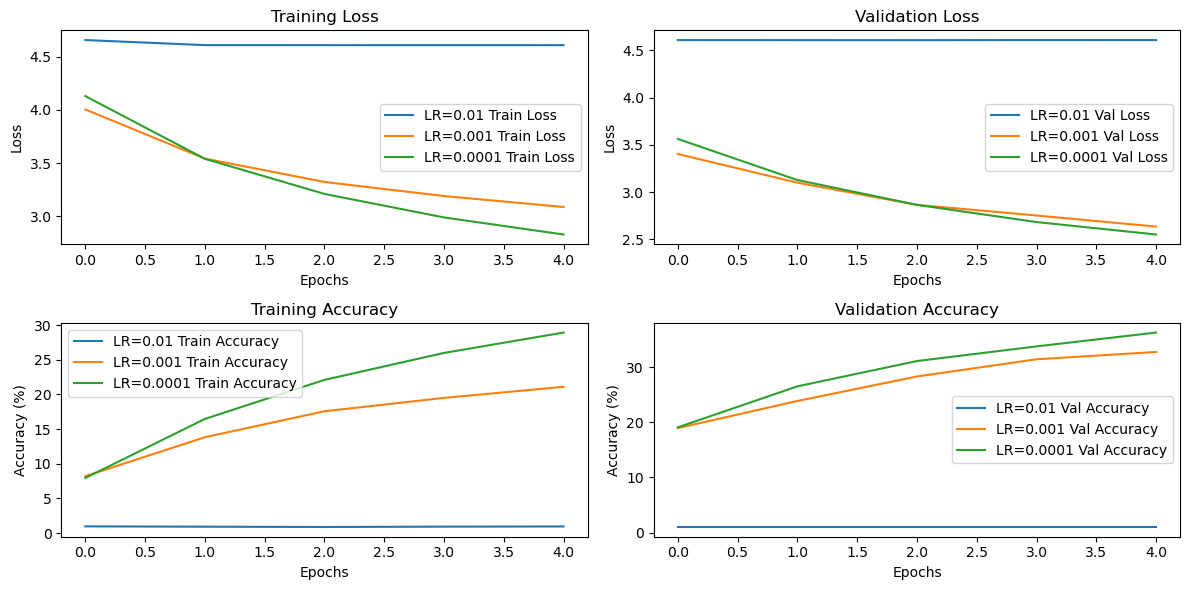

Epoch 1/5 | TrainLoss: 4.0406 | ValLoss: 3.4737 | TrainAcc: 7.5460% | ValAcc: 16.7500%


Epoch 2/5 | TrainLoss: 3.6165 | ValLoss: 3.1652 | TrainAcc: 12.5900% | ValAcc: 22.4200%


Epoch 3/5 | TrainLoss: 3.4178 | ValLoss: 2.9303 | TrainAcc: 15.3680% | ValAcc: 26.8200%


Epoch 4/5 | TrainLoss: 3.2883 | ValLoss: 2.8214 | TrainAcc: 17.5020% | ValAcc: 29.1900%


Epoch 5/5 | TrainLoss: 3.1778 | ValLoss: 2.7864 | TrainAcc: 19.2820% | ValAcc: 29.8000%


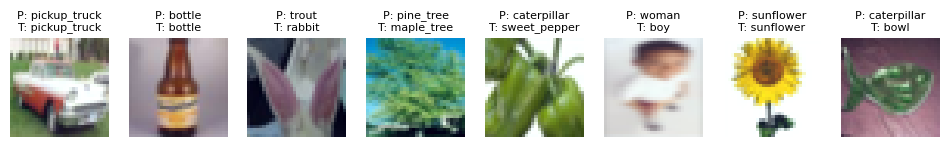


Training with Optimizer: Adam


Epoch 1/5 | TrainLoss: 4.0052 | ValLoss: 3.4028 | TrainAcc: 8.2200% | ValAcc: 18.9500%


Epoch 2/5 | TrainLoss: 3.5436 | ValLoss: 3.0992 | TrainAcc: 13.8360% | ValAcc: 23.8700%


Epoch 3/5 | TrainLoss: 3.3244 | ValLoss: 2.8652 | TrainAcc: 17.5780% | ValAcc: 28.3200%


Epoch 4/5 | TrainLoss: 3.1920 | ValLoss: 2.7524 | TrainAcc: 19.5100% | ValAcc: 31.4400%


Epoch 5/5 | TrainLoss: 3.0894 | ValLoss: 2.6353 | TrainAcc: 21.1060% | ValAcc: 32.7700%

Training with Optimizer: SGD


Epoch 1/5 | TrainLoss: 4.5743 | ValLoss: 4.4919 | TrainAcc: 1.8700% | ValAcc: 4.4500%


Epoch 2/5 | TrainLoss: 4.4618 | ValLoss: 4.3580 | TrainAcc: 3.9960% | ValAcc: 7.1600%


Epoch 3/5 | TrainLoss: 4.3436 | ValLoss: 4.2152 | TrainAcc: 5.4920% | ValAcc: 9.3300%


Epoch 4/5 | TrainLoss: 4.2329 | ValLoss: 4.0952 | TrainAcc: 6.8980% | ValAcc: 11.8300%


Epoch 5/5 | TrainLoss: 4.1357 | ValLoss: 3.9825 | TrainAcc: 8.1400% | ValAcc: 13.9200%

Training with Optimizer: RMSprop


Epoch 1/5 | TrainLoss: 4.2753 | ValLoss: 3.8301 | TrainAcc: 4.9060% | ValAcc: 10.8200%


Epoch 2/5 | TrainLoss: 3.8612 | ValLoss: 3.4708 | TrainAcc: 9.2120% | ValAcc: 17.1500%


Epoch 3/5 | TrainLoss: 3.6252 | ValLoss: 3.3866 | TrainAcc: 12.6380% | ValAcc: 19.3400%


Epoch 4/5 | TrainLoss: 3.4339 | ValLoss: 3.0644 | TrainAcc: 15.8240% | ValAcc: 23.5100%


Epoch 5/5 | TrainLoss: 3.3054 | ValLoss: 3.1607 | TrainAcc: 17.7140% | ValAcc: 21.3500%


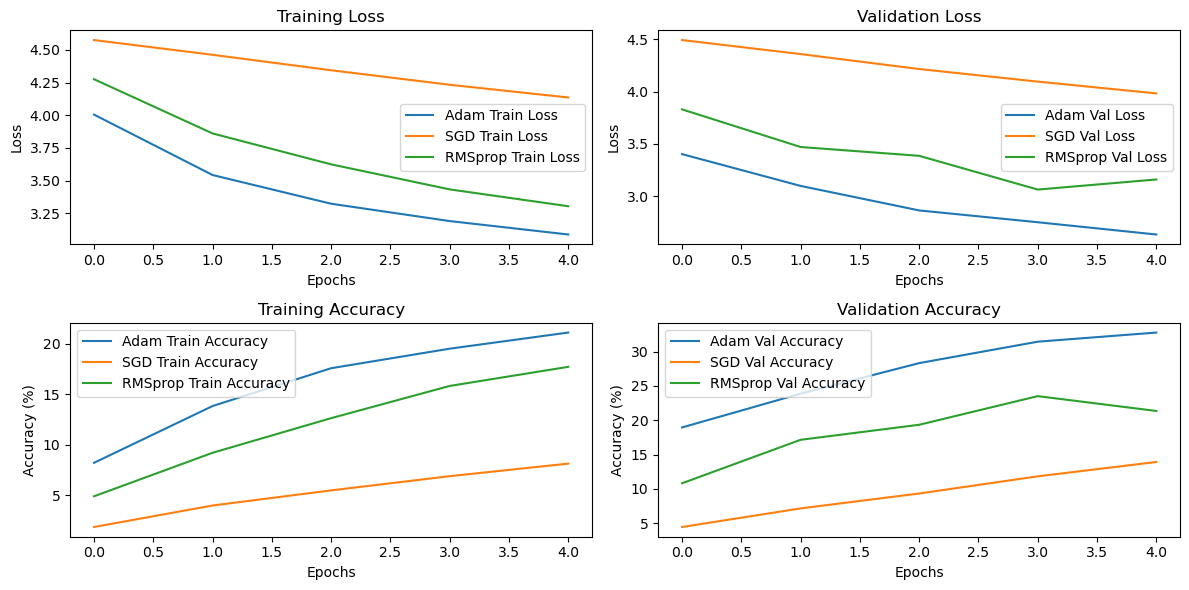


Training with Loss: CrossEntropy


Epoch 1/5 | TrainLoss: 4.0052 | ValLoss: 3.4028 | TrainAcc: 8.2200% | ValAcc: 18.9500%


Epoch 2/5 | TrainLoss: 3.5436 | ValLoss: 3.0992 | TrainAcc: 13.8360% | ValAcc: 23.8700%


Epoch 3/5 | TrainLoss: 3.3244 | ValLoss: 2.8652 | TrainAcc: 17.5780% | ValAcc: 28.3200%


Epoch 4/5 | TrainLoss: 3.1920 | ValLoss: 2.7524 | TrainAcc: 19.5100% | ValAcc: 31.4400%


Epoch 5/5 | TrainLoss: 3.0894 | ValLoss: 2.6353 | TrainAcc: 21.1060% | ValAcc: 32.7700%

Training with Loss: LabelSmoothing0.1


Epoch 1/5 | TrainLoss: 4.1787 | ValLoss: 3.7696 | TrainAcc: 7.2040% | ValAcc: 17.0000%


Epoch 2/5 | TrainLoss: 3.8497 | ValLoss: 3.4966 | TrainAcc: 12.5000% | ValAcc: 22.9400%


Epoch 3/5 | TrainLoss: 3.6869 | ValLoss: 3.3030 | TrainAcc: 15.7020% | ValAcc: 27.7700%


Epoch 4/5 | TrainLoss: 3.5971 | ValLoss: 3.2369 | TrainAcc: 17.5840% | ValAcc: 29.4700%


Epoch 5/5 | TrainLoss: 3.5250 | ValLoss: 3.1270 | TrainAcc: 19.1200% | ValAcc: 32.1700%


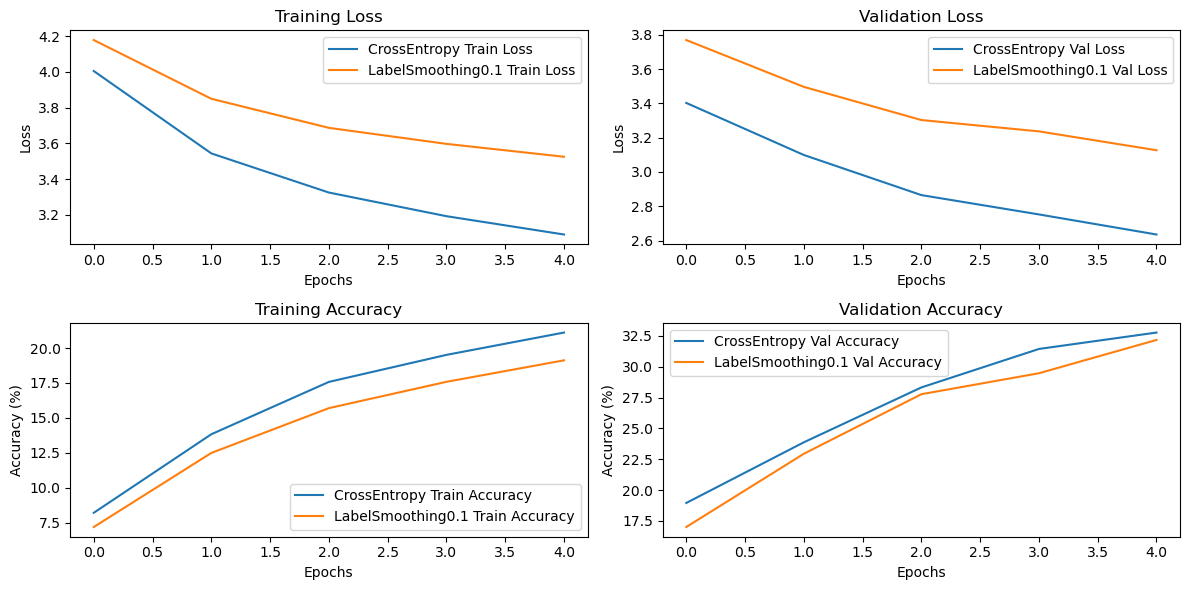

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 1
lrs = [1e-2, 1e-3, 1e-4]
results_lr = {}
for lr in lrs:
    print(f"\nTraining with LR={lr}")
    set_seed(0)
    model = make_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    history = train(model, train_loader, test_loader, criterion, optimizer, device, epochs=5)
    results_lr[f"LR={lr}"] = history
plot_training_curves(results_lr)

best_lr_model = make_model().to(device)
optimizer = optim.Adam(best_lr_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
history = train(best_lr_model, train_loader, test_loader, criterion, optimizer, device, epochs=5)
show_predictions(best_lr_model, test_loader, device)

# 2
#from torch.optim import Adam, SGD, RMSprop
optimizers = [Adam, SGD, RMSprop]
results_optimizer = {}
for opt_cls in optimizers:
    name = opt_cls.__name__
    print(f"\nTraining with Optimizer: {name}")
    set_seed(0)
    model = make_model().to(device)
    optimizer = opt_cls(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    history = train(model, train_loader, test_loader, criterion, optimizer, device, epochs=5)
    results_optimizer[name] = history
plot_training_curves(results_optimizer)

# 3
losses = {
    "CrossEntropy": nn.CrossEntropyLoss(),
    "LabelSmoothing0.1": nn.CrossEntropyLoss(label_smoothing=0.1)
}

results_loss = {}
for name, loss in losses.items():
    print(f"\nTraining with Loss: {name}")
    set_seed(0)
    model = make_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    history = train(model, train_loader, test_loader, loss, optimizer, device, epochs=5)
    results_loss[name] = history
plot_training_curves(results_loss)